# QSVT

The Quantum Singlar Value Transformation (QSVT) [[1]](#QSVT) is an algorithmic framework, used to apply polynomial transformation on the singular values of a block encoded matrix. It has wide range of applications such as matrix inversion, amplitude amplification and hamiltonian simulation.

Given a unitary $U$, a list of phase angles  $\phi_1, \phi_2, ..., \phi_{d+1}$ and 2 projector-controlled-not operands $C_{\Pi}NOT,C_{\tilde{\Pi}}NOT$ , the QSVT sequence is as follows:

$$ \tilde{\Pi}_{\phi_{d+1}}U \prod_{k=1}^{(d-1)/2} (\Pi_{\phi_{d-2k}} U^{\dagger}\tilde{\Pi}_{\phi_{d - (2k+1)}}U)\Pi_{\phi_{1}} $$
for odd $d$, and:
$$ \prod_{k=1}^{d/2} (\Pi_{\phi_{d-(2k-1)}} U^{\dagger}\tilde{\Pi}_{\phi_{d-2k}}U)\Pi_{\phi_{1}}$$
for even $d$.

Each of the projector-controlled-phase unitaries $\Pi$ consists of a $Z$ rotation of an auxilliary qubit wrapped by the $C_{\Pi}NOT$s, NOTing the auxilliary qubit:
$$\Pi_{\phi} = (C_{\Pi}NOT) e^{-i\frac{\phi}{2}Z}(C_{\Pi}NOT)$$
The transformation will result with a polynomial of order $d$.

Function: `qsvt`

Arguments:

- `phase_seq: CArray[CReal]` - a $d+1$ sized sequence of phase angles.
- `proj_cnot_1: QCallable[QArray[QBit], QBit]` - projector-controlled-not unitary that locates the encoded matrix columns within $U$. Accepts quantum variable of the size of `qvar`, and a qubit that is set to $|1\rangle$ when the state is in the block.
- `proj_cnot_2: QCallable[QArray[QBit], QBit]` - projector-controlled-not unitary that locates the encoded matrix rows within $U$. Accepts quantum variable of the size of `qvar`, and a qubit that is set to $|1\rangle$ when the state is in the block.
- `u: QCallable[QArray[QBit]]` - $U$ a block encoding unitary of a matrix $A$, such that $A = \tilde{\Pi}U\Pi$.
- `qvar: QArray[QBit]` - the quantum variable on which $U$ applies, which resides in the entire block encoding space.
- `aux: QBit` - a zero auxilliary qubit, used for the projector-controlled-phase rotations. Given as an input so that qsvt can be used as a building-block in a larger algorithm.

### Example: polynomial transformation on a $\sqrt(x)$ block encoding

The following example implements a random polynomial transformation on a given block, based on [[2]](#QSVT_derivative).
The unitary $U$ here is a square-root transformation: $U|x\rangle_n|0\rangle_{n+1} = |x\rangle_n(\sqrt{x}|\psi_0\rangle_{n}|0\rangle + \sqrt{1-x}|\psi_1\rangle_{n}|1\rangle)$ where $x$ is a fixed-point variable in the range $[0, 1)$.

The example samples a random odd-polynomial, calculates the necessary phase sequence using the package `pyqsp`, then applies the qsvt and verifies the results.

There are 2 distinct projector-controlled-not unitaries - one is applying on the entire $(n+1)$ variable, and the second is on the 1-qubits auxilliary in the image.

In [1]:
from typing import Dict, Tuple

import numpy as np
from numpy.polynomial import Polynomial
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

from classiq import *
from classiq.qmod.symbolic import logical_and

NUM_QUBITS = 4


class QSVTState(QStruct):
    state: QNum[NUM_QUBITS]
    ref: QNum[NUM_QUBITS]
    ind: QBit


@qfunc
def projector_cnot1(qsvt_state: Const[QSVTState], aux: Permutable[QBit]) -> None:
    aux ^= logical_and(qsvt_state.ref == 0, qsvt_state.ind == 0)


@qfunc
def projector_cnot2(qsvt_state: Const[QSVTState], aux: Permutable[QBit]) -> None:
    aux ^= qsvt_state.ind == 0


@qfunc
def u_sqrt(qsvt_state: QSVTState) -> None:
    hadamard_transform(qsvt_state.ref)
    qsvt_state.ind ^= qsvt_state.state <= qsvt_state.ref


@qfunc
def qsvt_sqrt_polynomial(
    qsvt_phases: CArray[CReal], qsvt_state: QSVTState, qsvt_aux: QBit
) -> None:
    qsvt(
        qsvt_phases,
        projector_cnot1,
        projector_cnot2,
        u_sqrt,
        qsvt_state,
        qsvt_aux,
    )

In [2]:
import matplotlib.pyplot as plt


def sample_random_chebyshev_polynomial(degree):
    # Generate random coefficients
    coefficients = np.random.uniform(-1, 1, degree + 1)
    # take care for parity
    coefficients[int(degree + 1) % 2 :: 2] = 0

    # Create the polynomial
    p = np.polynomial.Chebyshev(coefficients)
    # Evaluate the polynomial over the interval [-1, 1]
    x = np.linspace(-1, 1, 500)
    y = p(x)

    # Normalize the polynomial
    poly = p / np.max(np.abs(y))
    print(poly)
    return poly


def adjust_qsvt_convetions(phases: np.ndarray) -> np.ndarray:
    phases = np.array(phases)
    # change the R(x) to W(x), as the phases are in the W(x) conventions
    phases = phases - np.pi / 2
    phases[0] = phases[0] + np.pi / 4
    phases[-1] = phases[-1] + np.pi / 2 + (2 * DEGREE - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    return -2 * phases


def compute_qsvt_phases(coefficients):
    phases = QuantumSignalProcessingPhases(
        coefficients, signal_operator="Wx", method="laurent", measurement="x"
    )
    return adjust_qsvt_convetions(phases).tolist()


def parse_qsvt_results(result) -> Tuple[np.ndarray, np.ndarray]:
    parsed_state_vector = result.parsed_state_vector

    d: Dict = {x: [] for x in range(2**NUM_QUBITS)}
    for parsed_state in parsed_state_vector:
        if (
            parsed_state["qsvt_aux"] == 0
            and parsed_state["ind"] == 0
            and np.linalg.norm(parsed_state.amplitude) > 1e-15
            and (DEGREE % 2 == 1 or parsed_state["ref"] == 0)
        ):
            d[parsed_state["state"]].append(parsed_state.amplitude)
    d = {k: np.linalg.norm(v) for k, v in d.items()}
    values = [d[i] for i in range(len(d))]

    x = np.sqrt(np.linspace(0, 1 - 1 / (2**NUM_QUBITS), 2**NUM_QUBITS))

    measured_poly_values = np.sqrt(2**NUM_QUBITS) * np.array(values)
    target_poly_values = np.abs(POLY(x))

    plt.scatter(x, measured_poly_values, label="measured", c="g")
    plt.plot(x, target_poly_values, label="target")
    plt.xlabel(r"$\sqrt{x}$")
    plt.ylabel(r"$P(\sqrt{x})$")
    plt.legend()

    return measured_poly_values, target_poly_values

In [3]:
DEGREE = 5

np.random.seed(1)

# choosing in purpose odd polynomial
POLY = sample_random_chebyshev_polynomial(DEGREE)
QSVT_PHASES = compute_qsvt_phases(POLY)

0.0 + 0.3360769780903607·T₁(x) + 0.0·T₂(x) - 0.3015165069435525·T₃(x) +
0.0·T₄(x) - 0.6218355980931396·T₅(x)


In [4]:
@qfunc
def main(
    state: Output[QNum[NUM_QUBITS]],
    ref: Output[QNum[NUM_QUBITS]],
    ind: Output[QBit],
    qsvt_aux: Output[QBit],
) -> None:
    qsvt_state = QSVTState()
    allocate(qsvt_state)
    allocate(qsvt_aux)

    hadamard_transform(qsvt_state.state)
    qsvt_sqrt_polynomial(QSVT_PHASES, qsvt_state, qsvt_aux)

    bind(qsvt_state, [state, ref, ind])


qmod = create_model(
    main,
    constraints=Constraints(max_width=13),
    execution_preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
    out_file="qsvt",
)
qprog = synthesize(qmod)

In [5]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2yjqtc9XI9fDnhYUp5rbM7xnMmy


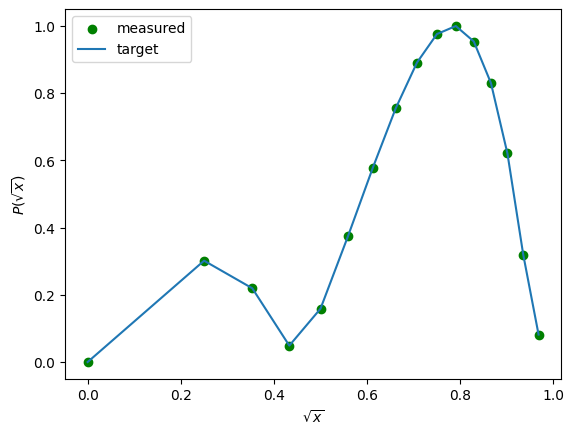

In [6]:
result = execute(qprog).result_value()

measured, target = parse_qsvt_results(result)
assert np.allclose(measured, target, atol=0.02)

## References

<a id='QSVT'>[1]</a>: András Gilyén, Yuan Su, Guang Hao Low, and Nathan Wiebe. 2019. Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing (STOC 2019). Association for Computing Machinery, New York, NY, USA, 193–204 https://doi.org/10.1145/3313276.3316366.

<a id='QSVT_derivative'>[2]</a>: Stamatopoulos, Nikitas, and William J. Zeng. "Derivative pricing using quantum signal processing." arXiv preprint arXiv:2307.14310 (2023).
